In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng(3210)

In [2]:

def pick_centres(K, image=None):
    """Intializes and returns K many centres from a uniform random distribution between 0 to 255 if image is None.
        Otherwise returns means that are equidistant"""
    if(image is not None):
        reshaped_img= image.reshape((-1,3))
        max=np.max(reshaped_img,axis=0)
        min=np.min(reshaped_img,axis=0)
        return np.linspace(min,max,num=K,endpoint=True,dtype=int)
        
    return rng.integers(0,255,size=(K,3),endpoint=True)


def cluster_data(image:np.ndarray, centres:np.ndarray):
    """Assigns each channel value to their appropiate cluster given mean"""
    assert centres.ndim == 2, "Centres must be 2D array. Actual shape is:{}".format(centres.shape)
    sorted_ind=np.argsort(centres,axis=0)
    sorted_centres=np.take_along_axis(centres,sorted_ind,axis=0)
    upper_bound= 0
    lower_bound= 0
    inCluster= None
    K=sorted_centres.shape[0]

    clusters= np.empty((image.shape+(K,)),dtype=int)

    for i in range(1,K+1):
        if(i < K):
            upper_bound=(sorted_centres[i] + sorted_centres[i-1])/2
            inCluster=np.logical_and(np.greater_equal(image,lower_bound),np.less(image,upper_bound))
        else:
            inCluster= np.greater_equal(image,upper_bound)
        inCluster= np.array(inCluster,dtype=int)
        clusters[:,:,:,i-1]= inCluster
        lower_bound=upper_bound
    return clusters

def find_centres(image:np.ndarray, clusters:list):
    """Calculates the new mean of each cluster of each channel"""
    K=clusters.shape[-1]
    centres= None
    for i in range(K):
        div=np.sum(clusters[...,i],axis=(0,1))
        div[div== 0]=1
        centre= np.sum(clusters[...,i]*image,axis=(0,1))/div
        centres= centre if i==0 else np.vstack((centres,centre))

    centres= centres.astype(int)
    return centres

def recontruct_image(means:np.ndarray,clusters:np.ndarray):
    """Recontructs image given K means and their associated clusters"""
    image= None
    counter=0
    for i in range(means.shape[0]):
        partial= clusters[:,:,:,i]*means[i]
        counter= np.sum(clusters[:,:,:,i]) + counter
        image= partial if image is None else image+partial
    
    return image

def find_MSE(orignal_image:np.ndarray,recontructed_image:np.ndarray):
    """Self explanatory"""
    diff= np.abs(orignal_image-recontructed_image)
    return np.sum(np.power(diff,2))**.5/orignal_image.size


In [8]:
def cluster_image(image:np.ndarray,K:int,randInit:bool=True):
    """Clusters the image. Uses early stopping to stop clustering when MSE doesn't improve for 5 adjecent iterations"""
    old_centres=pick_centres(K,image if not randInit else None)
    new_centres= None
    clusters= None
    MSE= None
    lowest_MSE=None
    best_model=None
    high_MSE_count=10
    counter=0

    while(True):
        clusters= cluster_data(image,old_centres)
        new_centres=find_centres(image,clusters)
        MSE= find_MSE(image,recontruct_image(old_centres,clusters))
        old_centres=new_centres
        counter= counter+1

        if(lowest_MSE is None or MSE< lowest_MSE):
            lowest_MSE=MSE
            best_model=(old_centres,clusters,counter)
            high_MSE_count=0
        elif(MSE>=lowest_MSE):
            high_MSE_count= high_MSE_count+1
            if(high_MSE_count > 5):
                print("MSE increasing, aborting training")
                break
        
        print("Done loop, MSE:{}".format(MSE))

    return best_model

def process_image(img):
    """Performs clustering on image for each value in k_arr. 
        Clustering is done 3 times; first 2 times is randoml last time is using equidistant initialization
        Recontructs the image after cluistering, prints the rectonructed image"""
    k_arr=[2,3,10,20,40]
    recontruction=None
    k_len=len(k_arr)

    plt.figure()
    plt.imshow(img)
    plt.title("Original Image")

    
    for i in range(k_len):
        for j in range(3):
            centres,clusters,convergence_count=cluster_image(img,k_arr[i],False if j==2 else True)
            recontruction= recontruct_image(centres,clusters)

            MSE= find_MSE(img,recontruction)
            
            init_string="non-" if j==2 else ""
            print("Iterations for convergence:{}".format(convergence_count))
            print("MSE for K={} and {}random init is {}".format(k_arr[i],init_string,MSE))

            
            plt.figure()
            plt.imshow(recontruction)
            plt.title("K={} and {}random init".format(k_arr[i], init_string))



Done loop, MSE:0.08543087188470005
Done loop, MSE:0.006055569524656369
Done loop, MSE:0.0054691300894544196
Done loop, MSE:0.005212076469295152
Done loop, MSE:0.005077137828760998
Done loop, MSE:0.004974331843579321
Done loop, MSE:0.004886277711770301
Done loop, MSE:0.004829313087659931
Done loop, MSE:0.004807017467556603
Done loop, MSE:0.004793895716198244
Done loop, MSE:0.004781211880335133
Done loop, MSE:0.004775690200135428
Done loop, MSE:0.0047773467761063676
Done loop, MSE:0.004779113324994955
Done loop, MSE:0.004781400236150432
Done loop, MSE:0.004781215825244236
Done loop, MSE:0.004779712818341625
MSE increasing, aborting training
Iterations for convergence:12
MSE for K=10 and random init is 0.004778789330502592
Done loop, MSE:0.09732392439733174
Done loop, MSE:0.008996301124782058
Done loop, MSE:0.007532206215174707
Done loop, MSE:0.006910249831653226
Done loop, MSE:0.006471293698150659
Done loop, MSE:0.006152474740715892
Done loop, MSE:0.005900666329375043
Done loop, MSE:0.00

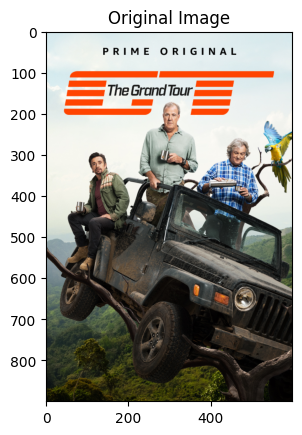

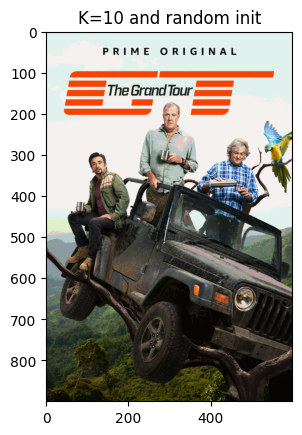

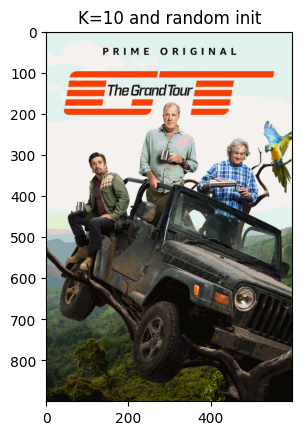

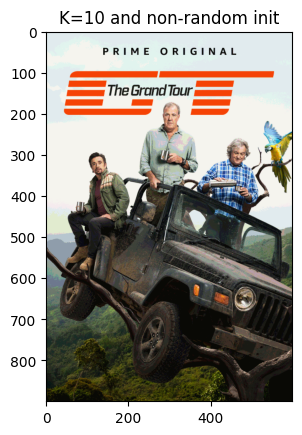

In [9]:
img=np.asarray(Image.open('Grand_Tour.jpg'))
process_image(img)


Done loop, MSE:0.08997019908850176
Done loop, MSE:0.04474876232344455
Done loop, MSE:0.044713337708067395
Done loop, MSE:0.04470098257458238
Done loop, MSE:0.04469847557737917
Done loop, MSE:0.044700528606321524
Done loop, MSE:0.04470050264172617
Done loop, MSE:0.04470050264172617
Done loop, MSE:0.04470050264172617
Done loop, MSE:0.04470050264172617
MSE increasing, aborting training
Iterations for convergence:5
MSE for K=2 and random init is 0.044700528606321524
Done loop, MSE:0.10750479156283983
Done loop, MSE:0.049118608017063935
Done loop, MSE:0.046434118201495754
Done loop, MSE:0.04534078734724291
Done loop, MSE:0.04495059549900902
Done loop, MSE:0.04479012282269477
Done loop, MSE:0.044725061195908467
Done loop, MSE:0.044702340424897666
Done loop, MSE:0.044690542643600936
Done loop, MSE:0.04469256913108068
Done loop, MSE:0.044694184813045254
Done loop, MSE:0.044694184813045254
Done loop, MSE:0.044694184813045254
Done loop, MSE:0.044694184813045254
MSE increasing, aborting training


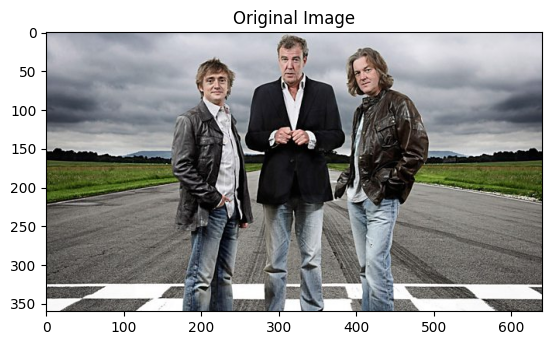

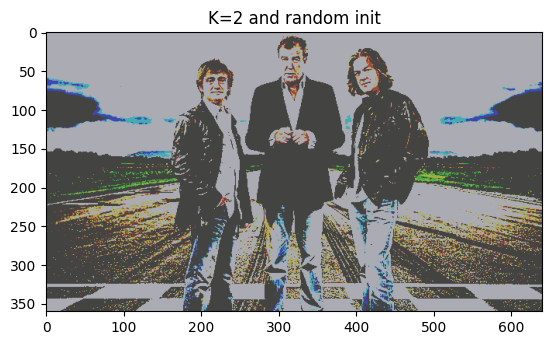

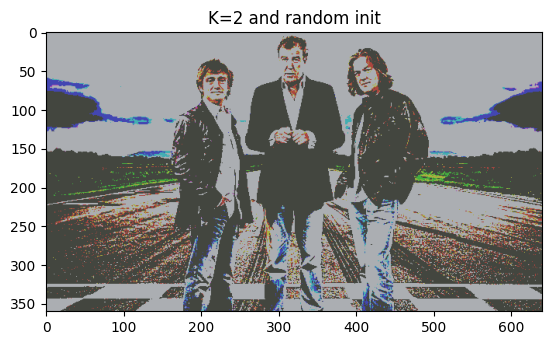

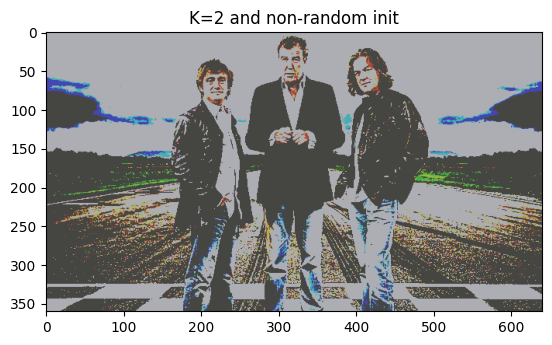

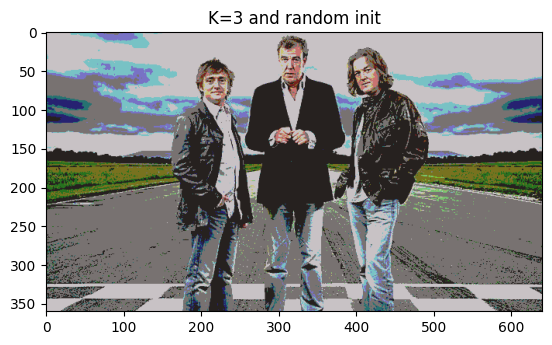

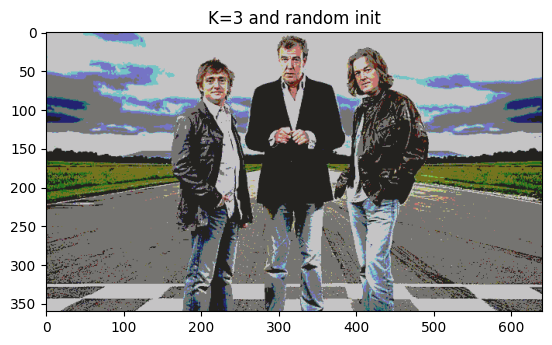

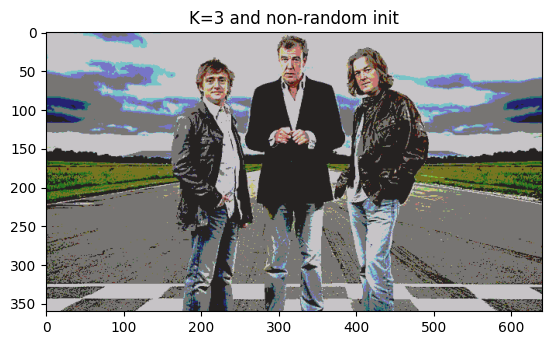

In [5]:
img=np.asarray(Image.open('Top_Gear.jpg'))
process_image(img)